In [1]:
# Demo of FGSM attacks vs FGN and Classical networks
# both targeted and untargeted 
# heavily modified from: https://blog.ycombinator.com/how-adversarial-attacks-work/

In [2]:
from __future__ import print_function

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np

import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [5]:
!gpustat

countdown  Tue Aug 13 14:48:06 2019
[0] GeForce GTX 1080 | 36'C,   0 % |  4168 /  8119 MB | felix(3603M) felix(553M)
[1] GeForce GTX 1080 | 37'C,   0 % |  2811 /  8118 MB | felix(1975M)


In [6]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)

# manualy set cuda device
torch.cuda.set_device(1)

CUDA Available:  True
Using device: cuda


In [7]:
# # random seeds
# torch.manual_seed(999)
# np.random.seed(999)

# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed_all(999)

In [8]:
# MNIST dataset and dataloader declaration
# transforms does both the conversion from 0-255 to 0-1
# and normalizes by the precomputed mean and std

batch_size = 2048

mnist_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../../MNIST-dataset', train=True, download=False, 
                   transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
            ])), 
        batch_size=batch_size, shuffle=False)

mnist_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../../MNIST-dataset', train=False, download=False, 
                   transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
            ])), 
        batch_size=batch_size, shuffle=False)

In [9]:
# load data by batch
for cln_data, true_label in mnist_train_loader:
    break
cln_data, true_label = cln_data.to(device), true_label.to(device)

In [10]:
# minimum/maximum pixel value post normalization, from entire dataset
min_pix = -0.4242129623889923095703125
print("min_pix", min_pix)
max_pix =  2.8214867115020751953125000
print("max_pix", max_pix)

# q? why are the min and max greater than the theoretical min? rounding errors?
# theoritical minimum
print( (0.0/255-0.1307)/0.3081 )
# theoritical maximum
print( (255.0/255-0.1307)/0.3081 )

min_pix -0.424212962389
max_pix 2.8214867115
-0.424212917884
2.82148653035


In [11]:
# load classic model
classic_model_path = "../Experiments/sample_models/sample_classic_model_noisy_eval_p0.66_full.pth"
classic_model = torch.load(classic_model_path)
classic_model.to(device)

Feedforward_Classic_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.03125)
    (1): Linear(in_features=784, out_features=32, bias=True)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.03125)
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.03125)
  )
  (ib): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): Linear(in_features=32, out_features=10, bias=True)
)

In [12]:
# test the model
# loss functions for the classic net      
classical_cross_ent_loss = (lambda model,output,target:  F.cross_entropy(output,target.long()))

classic_test_res = fgnh.test(classic_model, mnist_train_loader, classical_cross_ent_loss,
                               pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.2608, Accuracy: 55151/60000 (92%)


In [13]:
# load fgn model
fgn_model_path = "../Experiments/sample_models/sample_fgn_model_noisy_eval_p0.27_full.pth"
fgn_model = torch.load(fgn_model_path)
fgn_model.to(device)

Feedforward_FGN_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.03125)
    (1): FGN_layer()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.03125)
    (4): FGN_layer()
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.03125)
  )
  (ib): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): FGN_layer()
)

In [14]:
### Loss Functions for the FGN
fgn_cross_ent_loss = (lambda model,output,target:  F.cross_entropy(output,target.long()))

# test the model
fgn_test_res = fgnh.test(fgn_model, mnist_train_loader, fgn_cross_ent_loss,
                               pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.2914, Accuracy: 54274/60000 (90%)


In [15]:
# switch to random eval
fgn_model.set_random_eval(True)
fgn_test_res_random = fgnh.test(fgn_model, mnist_train_loader, fgn_cross_ent_loss,
                               pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.2914, Accuracy: 54274/60000 (90%)


In [16]:
# set models to eval mode
classic_model.eval()
fgn_model.eval()

Feedforward_FGN_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.03125)
    (1): FGN_layer()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.03125)
    (4): FGN_layer()
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.03125)
  )
  (ib): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): FGN_layer()
)

In [17]:
def draw_result(model, img, noise, adv_img):
    fig, ax = plt.subplots(1, 3, figsize=(8, 4))
    orig_class, attack_class = fgnh.get_class_from_pred(model, img), fgnh.get_class_from_pred(model, adv_img)
    ax[0].imshow(img[0].cpu().numpy(), cmap=plt.cm.get_cmap('Greys'), vmin=min_pix, vmax=max_pix)
    ax[0].set_title('Original image: {}'.format(orig_class))
    ax[1].imshow(noise[0], cmap=plt.cm.get_cmap('Greys'), vmin=min_pix, vmax=max_pix)
    ax[1].set_title('Attacking noise')
    ax[2].imshow(adv_img[0], cmap=plt.cm.get_cmap('Greys'), vmin=min_pix, vmax=max_pix)
    ax[2].set_title('Adversarial example: {}'.format(attack_class))
    
    for i in range(3):
        ax[i].set_axis_off()
    plt.tight_layout()
    plt.show()

In [18]:
### PART 1: untargeted FGSM attack

In [19]:
# attack params
input_data = cln_data[104]
max_noise = float(max_pix-min_pix)/64.0
step_size = float(max_pix-min_pix)/256.0
steps = 100

In [20]:
### Attack the classic net
classic_adv_img, classic_adv_noise, classic_results = fgnl.FGSM_attack_untargeted(model=classic_model, input_data=input_data,
                                                                                  data_bounds=(min_pix, max_pix),
                                                 max_noise=max_noise, loss_func=nn.CrossEntropyLoss(), 
                                                 step_size=step_size, steps=steps, confidence_req=0.9,
                                                 verbose=True)
print(classic_results)

Found wrong class 3 at step 24 with confidence 0.587653875351.
Attempting to increase confidence
New best found at step 26 with confidence 0.809087336063:
New best found at step 29 with confidence 0.84205698967:
New best found at step 32 with confidence 0.850618362427:
{'confidence': 0.85061836, 'steps': 99}


In [21]:
### Attack the fgn net
fgn_model.set_random_eval(True)
fgn_adv_img, fgn_adv_noise, fgn_results = fgnl.FGSM_attack_untargeted(model=fgn_model, input_data=input_data,
                                                                      data_bounds=(min_pix, max_pix),
                                                 max_noise=max_noise, loss_func=nn.CrossEntropyLoss(), 
                                                 step_size=step_size, steps=steps, confidence_req=0.9,
                                                 verbose=True)
print(fgn_results)

Found wrong class 2 at step 1 with confidence 0.275027900934.
Attempting to increase confidence
New best found at step 4 with confidence 0.275914490223:
New best found at step 5 with confidence 0.34354031086:
New best found at step 15 with confidence 0.358266323805:
New best found at step 21 with confidence 0.358636289835:
{'confidence': 0.3586363, 'steps': 99}


Classic Net attack: {'confidence': 0.85061836, 'steps': 99}


<IPython.core.display.Javascript object>


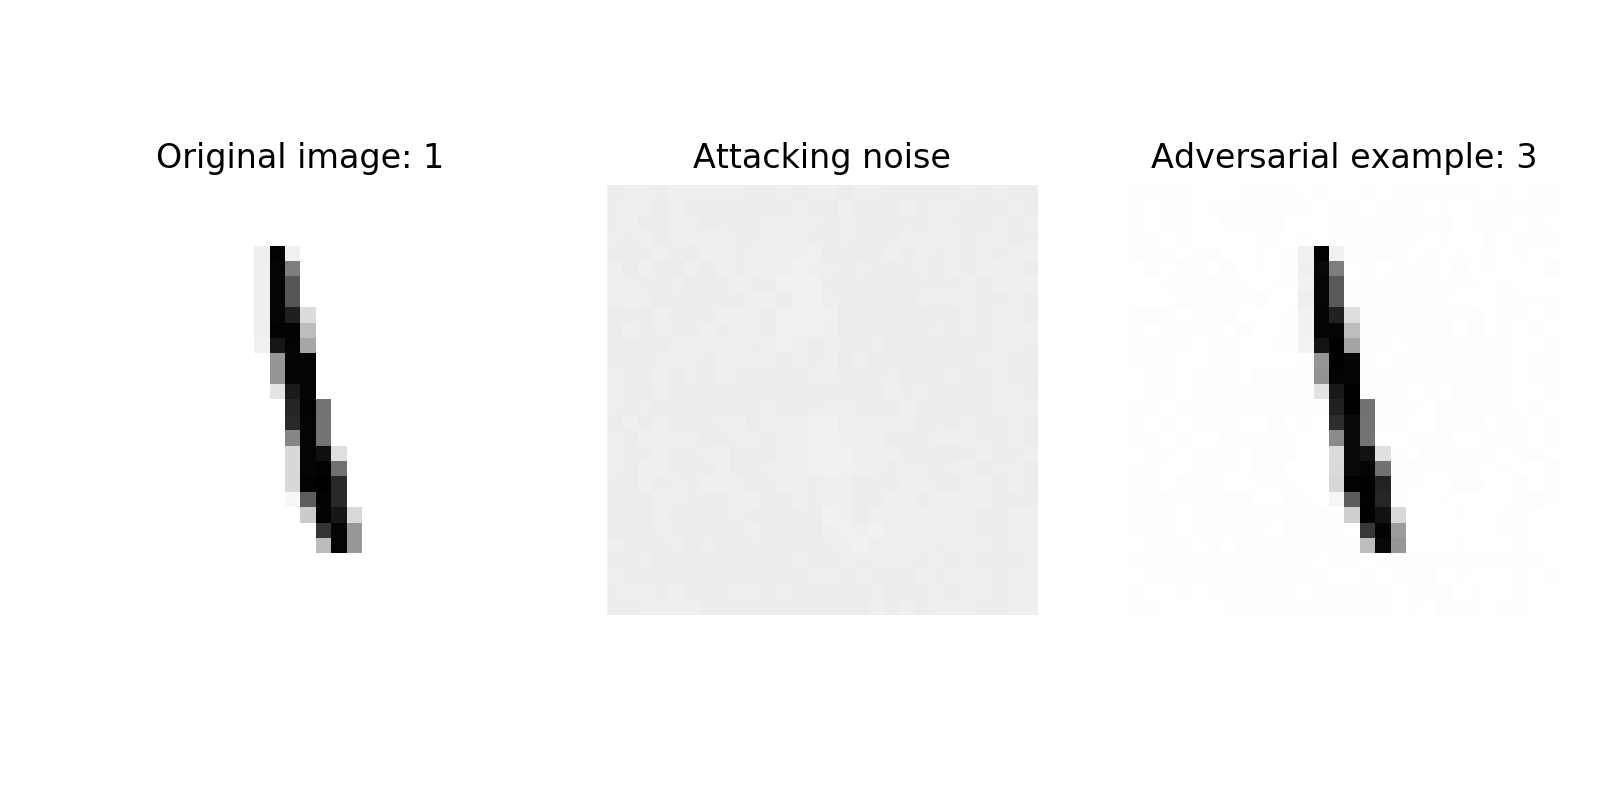

FGN attack: {'confidence': 0.3586363, 'steps': 99}


<IPython.core.display.Javascript object>


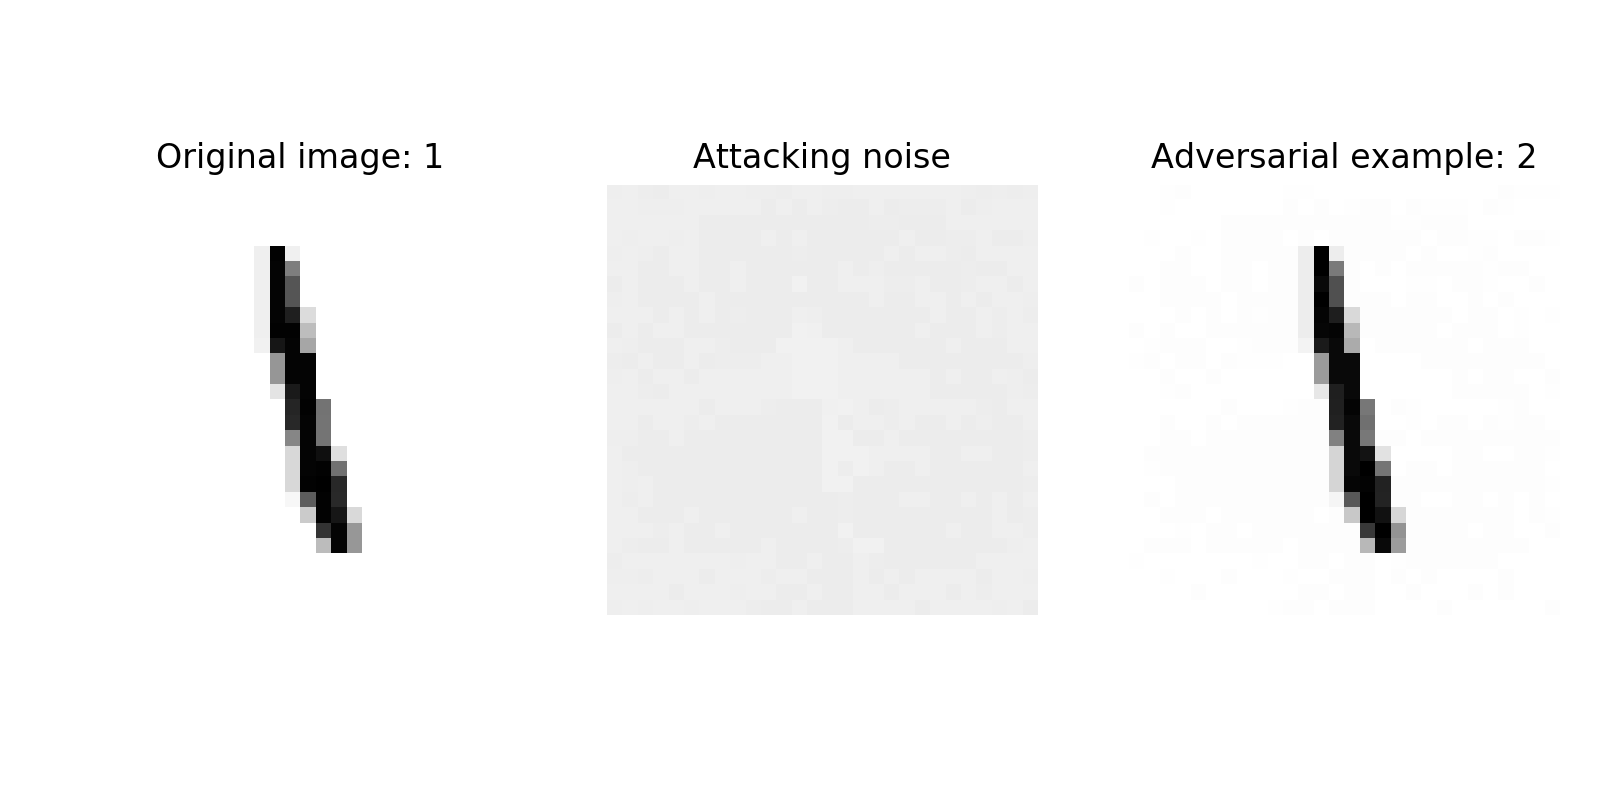

In [22]:
print("Classic Net attack:", classic_results)
draw_result(classic_model, input_data, classic_adv_noise, classic_adv_img)
print("FGN attack:", fgn_results)
draw_result(fgn_model, input_data, fgn_adv_noise, fgn_adv_img)

In [23]:
# # values to show:
# fgn_model.set_random_eval(True)
# model = classic_model/ FGN
# input_data = cln_data[103]
# max_noise = float(max_pix-min_pix)/64.0
# step_size = float(max_pix-min_pix)/100.0
# steps = 1000
# Classic finds adversarial right away, FGN takes time

# cln_data[103]: fgn can't reach same confidence

# 107, max_noise=/128: FGN finds adv but not classic
# 109: FGN fails because it's already class 2, dominant class. Classic finds an adv.

In [24]:
### PART 2: targeted FGSM attack

In [25]:
# attack params
input_data = cln_data[107]
target_class = 2

max_noise = float(max_pix-min_pix)/32.0
step_size = float(max_pix-min_pix)/64.0
steps = 1000

In [26]:
### Attack the classic net
classic_adv_img, classic_adv_noise, classic_results = fgnl.FGSM_attack_targeted(model=classic_model, input_data=input_data,
                                                                                target_class=target_class, data_bounds=(min_pix, max_pix),
                                                 max_noise=max_noise, loss_func=nn.CrossEntropyLoss(), 
                                                 step_size=step_size, steps=steps, confidence_req=0.9,
                                                 verbose=True)
print(classic_results)

Found target class 2 at step 6 with confidence 0.707255065441.
Attempting to increase confidence
Early stopping at step 9 with confidence 0.916463434696:
{'confidence': 0.91646343, 'steps': 9}


In [27]:
### Attack the fgn net
fgn_model.set_random_eval(True)
fgn_adv_img, fgn_adv_noise, fgn_results = fgnl.FGSM_attack_targeted(model=fgn_model, input_data=input_data,
                                                                    target_class=target_class, data_bounds=(min_pix, max_pix),
                                                 max_noise=max_noise, loss_func=nn.CrossEntropyLoss(), 
                                                 step_size=step_size, steps=steps, confidence_req=0.9,
                                                 verbose=True)
print(fgn_results)

Found target class 2 at step 1 with confidence 0.274907827377.
Attempting to increase confidence
{'confidence': 0.27490783, 'steps': 999}


Classic Net attack: {'confidence': 0.91646343, 'steps': 9}


<IPython.core.display.Javascript object>


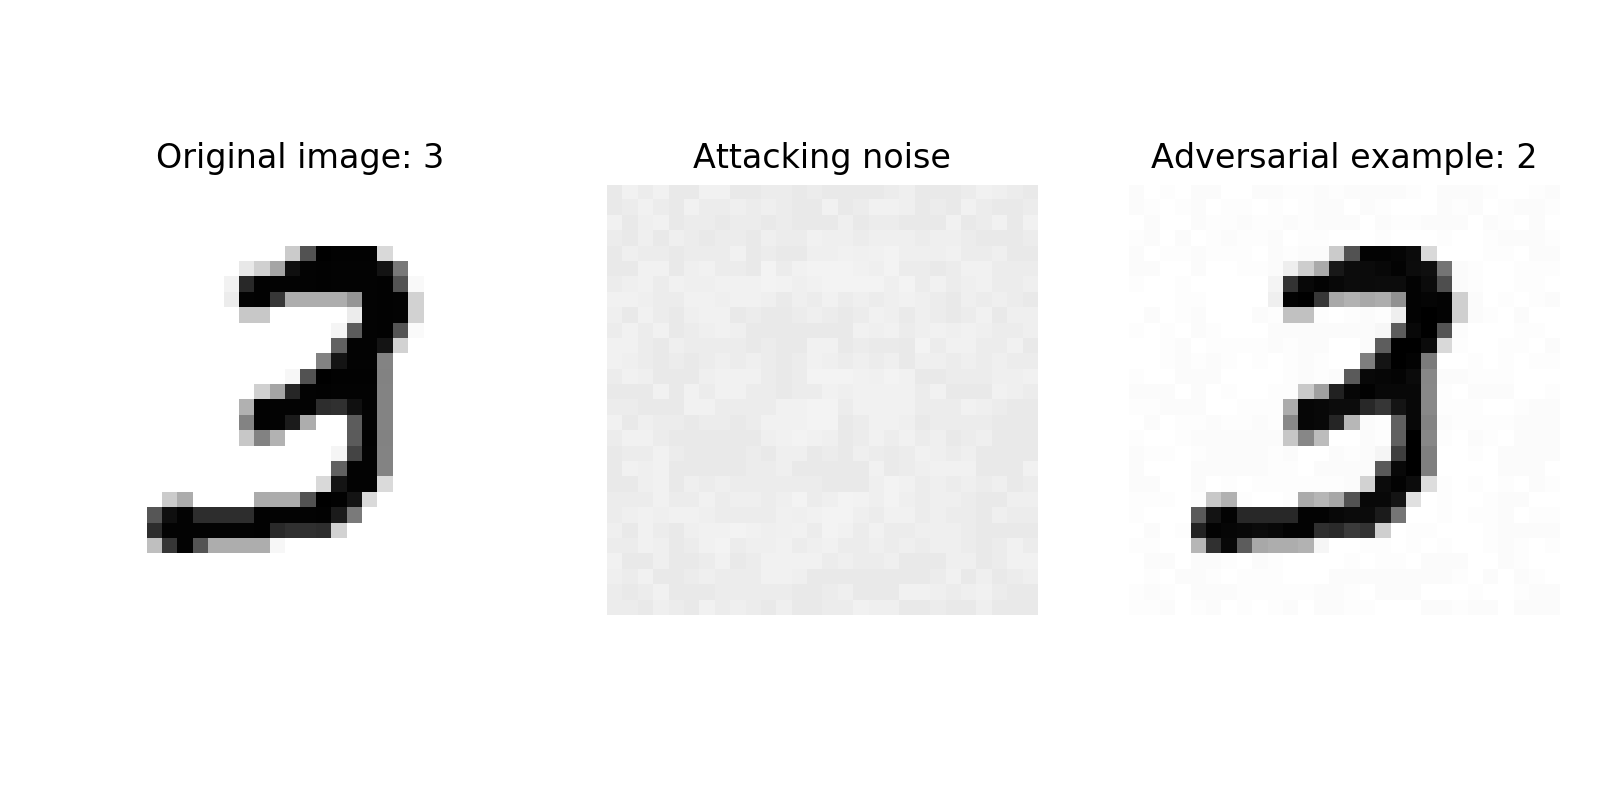

FGN attack: {'confidence': 0.27490783, 'steps': 999}


<IPython.core.display.Javascript object>


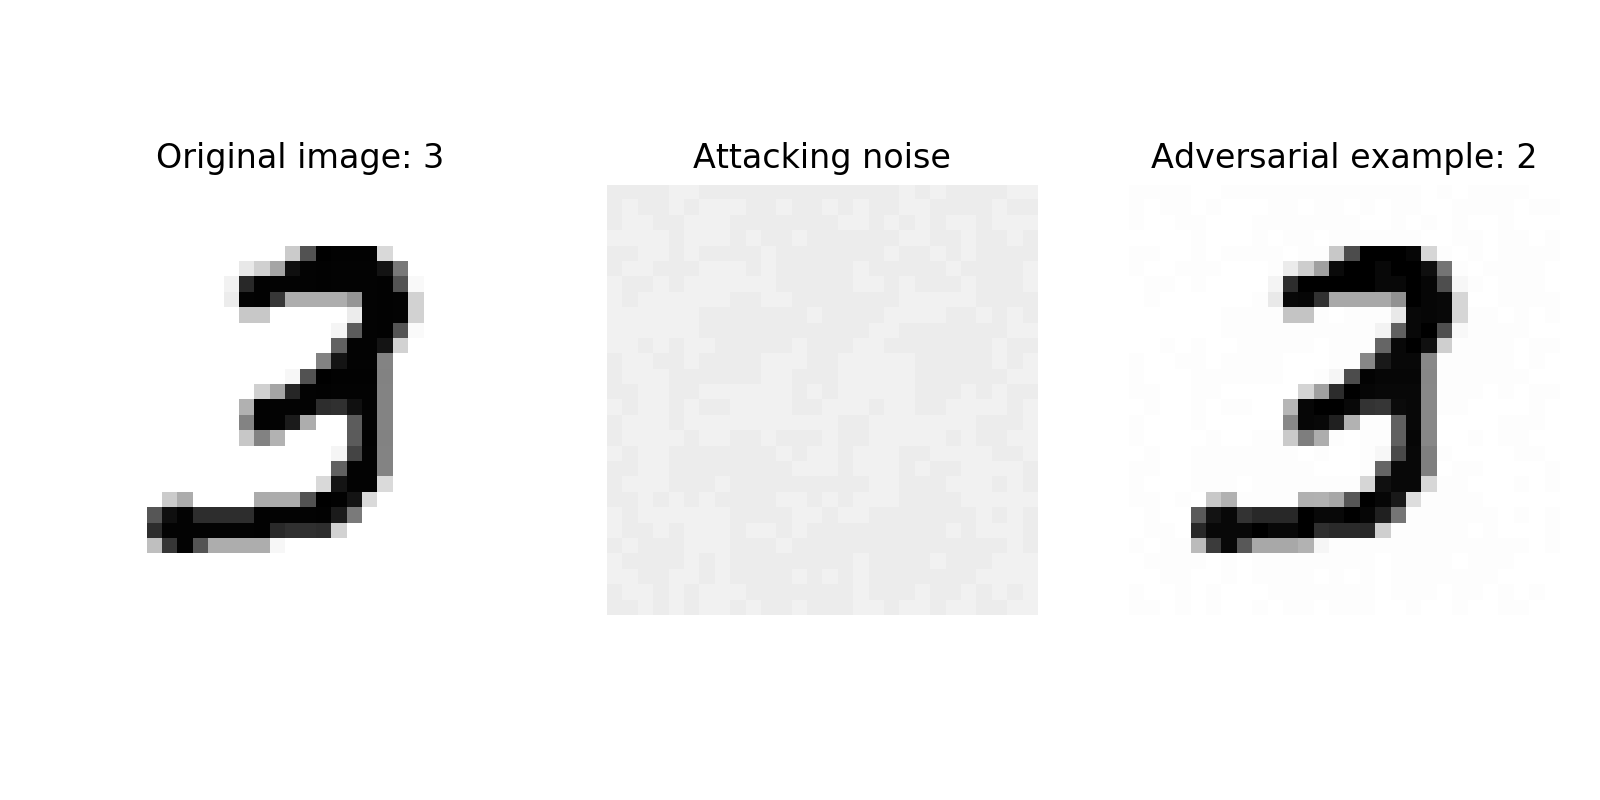

In [28]:
print("Classic Net attack:", classic_results)
draw_result(classic_model, input_data, classic_adv_noise, classic_adv_img)
print("FGN attack:", fgn_results)
draw_result(fgn_model, input_data, fgn_adv_noise, fgn_adv_img)

In [29]:
### Extra: how does random eval affect the attack on the fgn?
fgn_model.set_random_eval(False)
fgn_adv_img, fgn_adv_noise, fgn_results = fgnl.FGSM_attack_targeted(model=fgn_model, input_data=input_data,
                                                                    target_class=target_class, data_bounds=(min_pix, max_pix),
                                                 max_noise=max_noise, loss_func=nn.CrossEntropyLoss(), 
                                                 step_size=step_size, steps=steps, confidence_req=0.9,
                                                 verbose=True)
print(fgn_results)

Found target class 2 at step 1 with confidence 0.274907827377.
Attempting to increase confidence
{'confidence': 0.27490783, 'steps': 999}
